# Plotting MSLP During TC Winston
In this notebook we will try to visualize the MSLP during TC Winston. We will use data from ERA5 Reanalysis.

# Part 1: Load Data

In [32]:
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cartopy.crs as ccrs

In [3]:
file_path = 'D:/Projects/fiji-training-2024/notebooks/day_07/tc_winston.grib'
ds = xr.open_dataset(file_path, engine='cfgrib')
ds

<xarray.Dataset>
Dimensions:     (time: 264, latitude: 121, longitude: 121)
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2016-02-15 ... 2016-02-25T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 0.0 -0.25 -0.5 -0.75 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 150.0 150.2 150.5 ... 179.5 179.8 180.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u10         (time, latitude, longitude) float32 ...
    v10         (time, latitude, longitude) float32 ...
    msl         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-01T17:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Evaluate time coordinate
ds['time']

<xarray.DataArray 'time' (time: 264)>
array(['2016-02-15T00:00:00.000000000', '2016-02-15T01:00:00.000000000',
       '2016-02-15T02:00:00.000000000', ..., '2016-02-25T21:00:00.000000000',
       '2016-02-25T22:00:00.000000000', '2016-02-25T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2016-02-15 ... 2016-02-25T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  (time) datetime64[ns] ...
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [6]:
# Evaluate MSLP variable
ds['msl']

<xarray.DataArray 'msl' (time: 264, latitude: 121, longitude: 121)>
[3865224 values with dtype=float32]
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2016-02-15 ... 2016-02-25T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 0.0 -0.25 -0.5 -0.75 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 150.0 150.2 150.5 ... 179.5 179.8 180.0
    valid_time  (time) datetime64[ns] ...
Attributes: (12/30)
    GRIB_paramId:                             151
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      14641
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           msl
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:                                Mean sea level pressure
    units:                                    Pa
    standard_name:                            air_pressure_at_mean_sea_level

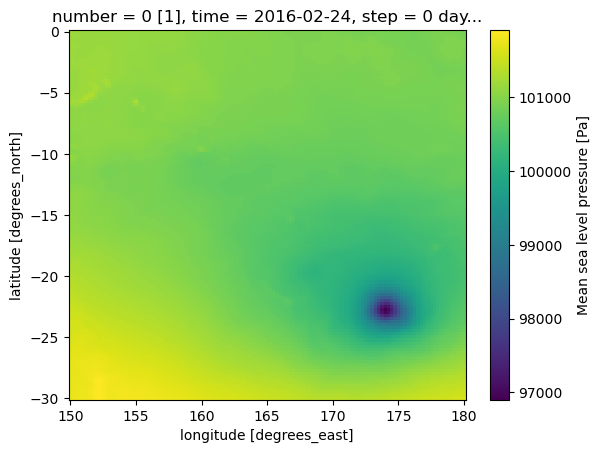

In [19]:
# Do some plot to see the coverage
ds['msl'].isel(time=150).plot() #try to change the time value to see the evolution
ds['msl'].sel(time=datetime(2016,2,24,0)).plot()

# Part 2: Prepare the Data
Now you have decided what time you want to plot, now let's prepare the data.

In [8]:
# Select the time and assign to a variable
time_select = datetime(2016,2,24,0)
msl = ds['msl'].sel(time=time_select)
msl = msl/100 # Convert to hPa
lons = msl.longitude
lats = msl.latitude

In [33]:
# Find the indices of the minimum MSLP value
min_index = msl.argmin(dim=['latitude', 'longitude'])

# Retrieve the latitude and longitude values at the minimum MSLP location
tc_lat = msl['latitude'][min_index['latitude']]
tc_lon = msl['longitude'][min_index['longitude']]


# Part 3: Plot the Data

In [11]:
# Define the contour levels
# levels = [990, 1000, 1002,1004, 1006, 1010,1012,1014,1016,1018,1020,1024,1028] # Define the levels here or use range 
levels = range(800,1028,2)

Text(0.5, 1.0, 'Mean Sea Level Pressure (hPa) - 2016/02/24 00:00')

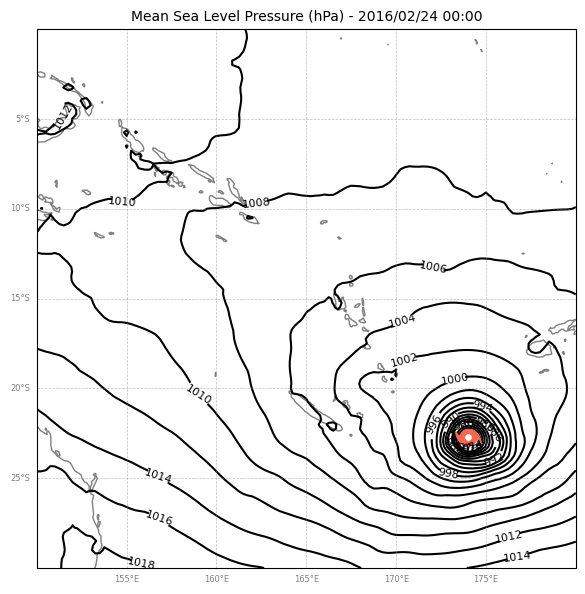

In [45]:
#==================Basic plot==================
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree()})

contour = ax.contour(lons, lats, msl, transform=ccrs.PlateCarree(), colors='black', levels=levels)
#==============================================

# Add contour labels
ax.clabel(contour, inline=True, fontsize=8)

# Add coastlines
ax.coastlines(color='gray', edgecolor='gray')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'gray'}
gl.ylabel_style = {'size': 6, 'color': 'gray'}

ax.set_xlabel('Longitude',fontsize=5)
ax.set_ylabel('Latitude',fontsize=5)

# Add TC symbol
# Load and add the tropical cyclone image
cyclone_image_path = 'D:/Projects/fiji-training-2024/notebooks/day_07/hurricane.png'  # Replace with the actual path to the cyclone image
cyclone_image = plt.imread(cyclone_image_path)
imagebox_cyclone = OffsetImage(cyclone_image, zoom=0.3)  # Adjust the zoom level to resize the cyclone image

# Convert latitude and longitude to projection coordinates
xy = ax.projection.transform_point(tc_lon, tc_lat, ccrs.PlateCarree())
ab_cyclone = AnnotationBbox(imagebox_cyclone, xy, frameon=False)
ax.add_artist(ab_cyclone)

# Add title
ax.set_title(f'Mean Sea Level Pressure (hPa) - {time_select:%Y/%m/%d %H:%M}', fontsize=10)